In [24]:
import flax
import dill as pickle
import builtins
from jax._src.lib import xla_client
import tensorflow as tf
import argparse
import math
import os
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap
from jax.example_libraries.optimizers import adam
from functools import partial
from flax.training.common_utils import shard
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from functools import partial
from flax.training.common_utils import shard
import transformers
import jax.image as jimg
import random as ran
import functools

In [25]:
builtins.bfloat16 = xla_client.bfloat16
def pickle_load(filename):
    """ Wrapper to load an object from a file."""
    with tf.io.gfile.GFile(filename, 'rb') as f:
        pickled = pickle.loads(f.read())
    return pickled
# model=pickle_load("/home/beich/majesty/project/checkpoints/ckpt_360000.pickle")# Long WISE
# model=pickle_load("/home/beich/majesty/project/WISE1-40000_best.pickle")
# model=pickle_load("/home/beich/majesty/project/stylegan2-flax-tpu/checkpoints/ckpt_392000_best.pickle")# Square SHHQ
model=pickle_load("/home/beich/majesty/project/checkpoints/ckpt_930000.pickle")# Long SHHQ


G=model['state_G']


In [26]:

processor=transformers.CLIPProcessor.from_pretrained("/home/beich/majesty/project/CLIP-fashiongen/ckpt-9")

In [27]:

from jax.lax import dynamic_slice
class CLIPLoss(flax.linen.Module):

    def __init__(self, opts,text_id,text_mask):
        self.processor = transformers.CLIPProcessor.from_pretrained("/home/beich/majesty/project/CLIP-fashiongen/ckpt-9")
        self.model = transformers.FlaxCLIPModel.from_pretrained("/home/beich/majesty/project/CLIP-fashiongen/ckpt-9")
        self.upsample = jax.image.resize
        self.avg_pool = partial(flax.linen.avg_pool, window_shape=(opts.stylegan_size // 32, opts.stylegan_size // 32, ))
        self.rng = random.PRNGKey(0)
        self.text_feature=self.model.get_text_features(text_id,text_mask)

#     def __call__(self, image, ):
#         upper = dynamic_slice(image, (0,0, 0, 0), (image.shape[0],512, 512, image.shape[-1]))
#         bottom = dynamic_slice(image, (0,512, 0, 0), (image.shape[0],1024, 512, image.shape[-1]))
#         upsampled_upper = self.upsample(upper, (image.shape[0], 224, 224, image.shape[-1]), "bilinear")
        
#         upsampled_bottom = self.upsample(bottom, (image.shape[0], 224, 224, image.shape[-1]), "bilinear")
        
#         pooled_upper= self.avg_pool(upsampled_upper)
#         pooled_bottom = self.avg_pool(upsampled_bottom)
        
#         inputs_upper = self.processor(images=pooled_upper,  return_tensors="jax", do_center_crop=False,do_rescale=False)
        
#         inputs_bottom = self.processor(images=pooled_bottom,  return_tensors="jax", do_center_crop=False,do_rescale=False)
#         img_feature_upper=self.model.get_image_features(**inputs_upper)
#         img_feature_bottom=self.model.get_image_features(**inputs_bottom)
#         img_feature=(img_feature_upper+img_feature_bottom)/2
# #         inputs = shard(inputs)
# #         input_image= jnp.expand_dims(jnp.mean(inputs["pixel_values"], axis=0), axis=0)

# #         input_image= jnp.mean(inputs["pixel_values"], axis=0)
# #         result = self.model(input_ids=text_id,attention_mask =text_mask,pixel_values=inputs["pixel_values"])
#         result=img_feature@self.text_feature.T
#         similarity = 1 - result[0][0] / 100
#         return similarity
    def __call__(self, image, ):
        upsampled_upper = self.upsample(image, (image.shape[0], 224, 224, image.shape[-1]), "bilinear")
        
        
        pooled_upper= self.avg_pool(upsampled_upper)
        
        inputs_upper = self.processor(images=pooled_upper,  return_tensors="jax", do_center_crop=False,do_rescale=False)
        
        img_feature=self.model.get_image_features(**inputs_upper)
#         inputs = shard(inputs)
#         input_image= jnp.expand_dims(jnp.mean(inputs["pixel_values"], axis=0), axis=0)

#         input_image= jnp.mean(inputs["pixel_values"], axis=0)
#         result = self.model(input_ids=text_id,attention_mask =text_mask,pixel_values=inputs["pixel_values"])
        result=img_feature@self.text_feature.T
        similarity = 1 - result[0][0] / 100
        return similarity

In [28]:
def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)
    return initial_lr * lr_ramp


def generator_mean_latent(generator, n_latent, rng):
    latent_in = random.normal(rng, (n_latent, 512))

    latent = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},latent_in,c=jnp.array([[0,0,0,0,1],[0,0,0,0,1]]),train=False).mean(0, keepdims=True)
    return latent



In [58]:
img_orig=None
import jax.image as jimg
def main(args):
    truncation_psi=args.truncation_psi
    text_inputs = processor(args.description, return_tensors="jax")
    os.makedirs(args.results_dir, exist_ok=True)

    rng = jax.random.PRNGKey(ran.randint(1,10000))
#     g_ema = Generator(args.stylegan_size, 512, 8)
#     g_ema.load_weights(args.ckpt)
#     g_ema.eval()

    mean_latent = generator_mean_latent(G, 10000, rng)
    latent_code_init = jnp.repeat(mean_latent, 2, axis=0)
    global img_orig

    img_orig = G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},latent_code_init, noise_mode='none')

    latent = jnp.array(latent_code_init, dtype=jnp.float32)
    clip_loss = CLIPLoss(args, text_inputs['input_ids'],text_inputs['attention_mask'])

    # Initialize Adam optimizer with learning rate and latent as parameters
    optimizer_init, optimizer_update, get_params = adam(args.lr)
    optimizer_state = optimizer_init(latent)

    @jit
    def update(rng, t, optimizer_state):
        latent = get_params(optimizer_state)
        img_gen =  G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},truncation_psi * latent + (1 - truncation_psi) * mean_latent , noise_mode='none')

        # Assuming `image` is a 3D array representing the image

        # Resize the image using `jax.image.resize`
        a,new_height, new_width,d=img_gen.shape[0],1024,512,img_gen.shape[-1]
        resized_image = jimg.resize(img_gen, (a,new_height, new_width,d), method='bilinear')

        similarity = clip_loss((resized_image+1)/2)
        loss = jnp.mean(similarity)
        g = grad(lambda l: jnp.mean(clip_loss((jimg.resize
                                               (G.apply_synthesis(
                                                   {'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},l, noise_mode='none'),
                                                (a,new_height, new_width,d), method='bilinear')+1)/2
            )))(latent)
        optimizer_state = optimizer_update(t, g, optimizer_state)
        return rng, optimizer_state, loss

    @functools.wraps(update)
    def cached_update(rng, t, optimizer_state):
        global cache
        
        key = (t,)  # Use a tuple with only `t` as the key
        if key not in cache:
            cache[key] = update(rng, t, optimizer_state)
        return cache[key]


    pbar = tqdm(range(args.step))
    for i in pbar:
        t = i / args.step
        lr = get_lr(t, args.lr)
        rng, optimizer_state, loss = update(rng, i, optimizer_state,)
        print(f"{loss.item():.4f}")
        pbar.set_description(f"loss: {loss.item():.4f};")
        if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
            img_gen=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},get_params(optimizer_state), noise_mode='none')
            img_np = np.array((img_gen[0]
                .clip(-1, 1) * 127.5 + 127.5).astype(np.uint8))
            img = Image.fromarray(img_np, mode="RGB")
            img.save(f"{args.results_dir}/{str(i).zfill(5)}.jpg")

    img_gen=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},get_params(optimizer_state), noise_mode='none')

    img_np = np.array((img_gen[0].clip(-1, 1) * 127.5 + 127.5).astype(np.uint8))
    img = Image.fromarray(img_np, mode="RGB")
    img.save(os.path.join(args.results_dir, "final_result.jpg"))


class Args:
    def __init__(
        self,
        description="a person with purple hair",
        lr_rampup=0.05,
        lr=0.1,stylegan_size=512,
        step=300,
        save_intermediate_image_every=20,
        results_dir="results",
        truncation_psi=0.7
    ):
        self.description = description
        self.lr_rampup = lr_rampup
        self.lr = lr
        self.stylegan_size=stylegan_size
        self.step = step
        self.save_intermediate_image_every = save_intermediate_image_every
        self.results_dir = results_dir
        self.truncation_psi=truncation_psi

# Replace the argparse lines with the following code
args = Args(
    description="The elderly man wore a sharp, tailored suit with a crisp, white shirt and a colorful tie.",
    lr_rampup=0.05,
    lr=8e-4,
    step=1001,stylegan_size=512,
    save_intermediate_image_every=2,
    results_dir="resultsWISE",
    truncation_psi=1
)
result_image = main(args)


  0%|          | 0/1001 [00:00<?, ?it/s]

0.7908
0.7896
0.7874
0.7861
0.7843
0.7825
0.7812
0.7800
0.7788
0.7776
0.7765
0.7754
0.7737
0.7731
0.7719
0.7708
0.7697
0.7685
0.7680
0.7654
0.7649
0.7636
0.7622
0.7609
0.7596
0.7585
0.7578
0.7562
0.7550
0.7538
0.7534
0.7517
0.7508
0.7496
0.7487
0.7482
0.7474
0.7469
0.7456
0.7444
0.7436
0.7427
0.7423
0.7418
0.7407
0.7399
0.7391
0.7387
0.7376
0.7370
0.7365
0.7357
0.7350
0.7339
0.7331
0.7329
0.7322
0.7312
0.7306
0.7301
0.7289
0.7281
0.7272
0.7269
0.7259
0.7253
0.7244
0.7243
0.7229
0.7221
0.7220
0.7210
0.7209
0.7201
0.7199
0.7195
0.7190
0.7189
0.7182
0.7180
0.7176
0.7172
0.7171
0.7165
0.7163
0.7156
0.7156
0.7153
0.7151
0.7145
0.7148
0.7141
0.7136
0.7132
0.7132
0.7120
0.7129
0.7119
0.7120
0.7113
0.7110
0.7111
0.7104
0.7102
0.7100
0.7095
0.7097
0.7093
0.7088
0.7088
0.7084
0.7081
0.7080
0.7075
0.7069
0.7073
0.7068
0.7065
0.7062
0.7060
0.7059
0.7057
0.7054
0.7053
0.7043
0.7043
0.7042
0.7042
0.7038
0.7036
0.7033
0.7033
0.7027
0.7022
0.7026
0.7027
0.7024
0.7022
0.7021
0.7015
0.7015
0.7013
0.7017

In [56]:
cache = {}


In [10]:
type(jnp.repeat(mean_latent, 18, axis=0))

jaxlib.xla_extension.DeviceArray

TypeError: randint() missing 2 required positional arguments: 'a' and 'b'

In [8]:
r=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},mean_latent, train=False,noise_mode='none')


In [10]:
r.shape

(1, 512, 512, 3)

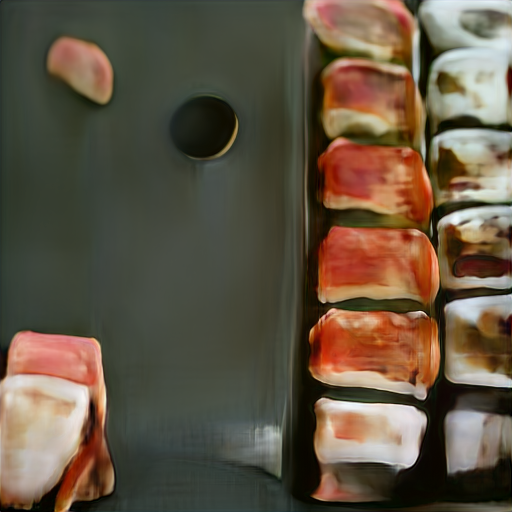

In [9]:
Image.fromarray(np.clip(((np.array( jnp.mean(r, axis=0))+1)*255/2),0,255).astype(np.uint8))

In [42]:
np.min(np.array( jnp.mean(img_orig, axis=0)))

-1.1015625

In [41]:
np.array(img_orig[17]).all() ==np.array(img_orig[0]).all()

True

In [ ]:
mean_latent

In [ ]:
display(Image.open('resultsWISE/00048.jpg'))

In [35]:
display(Image.open('results/00290.jpg'))

In [38]:
os.path.isfile("results/00010.jpg")

In [36]:

from tqdm.notebook import tqdm

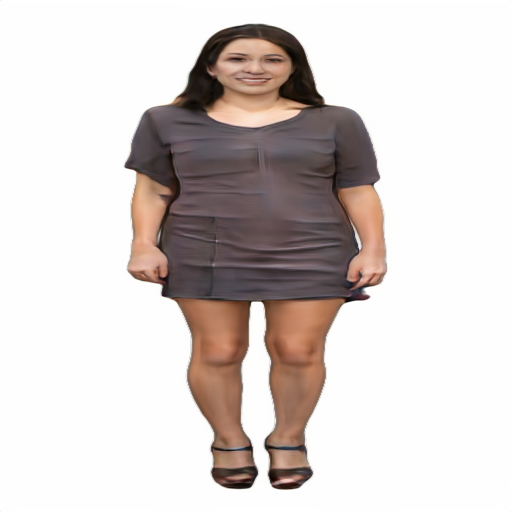

In [96]:
rng = jax.random.PRNGKey(100)
mean_latent = generator_mean_latent(G, 10000, rng)
r=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},mean_latent, noise_mode='none')
Image.fromarray(np.clip(((np.array( jnp.mean(r, axis=0))+1)*255/2),0,255).astype(np.uint8))

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__dataclass_transform__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_fn',
 'apply_gradients',
 'apply_mapping',
 'apply_synthesis',
 'create',
 'dynamic_scale_main',
 'dynamic_scale_reg',
 'epoch',
 'moving_stats',
 'noise_consts',
 'opt_state',
 'params',
 'replace',
 'step',
 'tx']

In [49]:
 dir(G.params['const'])

KeyError: 'const'

In [48]:
G['const']

TypeError: 'TrainStateG' object is not subscriptable

In [63]:
import jax
import jax.numpy as jnp
from jax import random

def mean_w(generator, num_points, rng_seed=0):
    rng = random.PRNGKey(rng_seed)
    z_points = random.normal(rng, (num_points, 512))
    w_points = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},z_points,train=False)
    mean_w = jnp.mean(w_points, axis=0)
    return mean_w

def generator_mean_latent(generator, n_latent, rng):
    latent_in = random.normal(rng, (n_latent, 512))

    latent = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},latent_in,c=jnp.array([[0,0,0,0,1],[0,0,0,0,1]]),train=False).mean(0, keepdims=True)
    return latent

# Usage:
# mapping_network: instance of your MappingNetwork class
# num_points: the number of random z points you want to use
mean_w_values = mean_w(G, num_points=100)

In [64]:
print(mean_w_values)

[[ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]
 [ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]
 [ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]
 ...
 [ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]
 [ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]
 [ 0.01302902  0.09264337  0.14618976 ...  0.15954326 -0.03190444
   0.06660704]]
